# Pre-Procesamiento

In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd
import torch
import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

from sklearn.model_selection import train_test_split

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [127]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Fijamos la semilla:

In [128]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [129]:
set_seed(42)

Parametros de la notebook:

In [130]:
DATASET_PATH = '../../datasets'

!mkdir -p {DATASET_PATH}

In [131]:
# Se excluyen categorias con menos de 5 productos.
MIN_PRODUCT_BY_CATEGORY = 5

# Se excluyen prodcutos con un title de mas de 150 caracteres.
MAX_PRODUCT_TITLE_SIZE  = 150

### Funciones helper

In [132]:
def plot_categories(groups):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=groups['category'], y='title', data=groups)
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    plt.show()
    
def plot_title(df, column, title):
    df = df.sort_values([column], ascending=False)
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x=column, y='title', data=df)
    ax.set(ylabel=None)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()

## Procedimiento

**Step 1**: Cargamos el dataset.

In [178]:
raw_dataset = pd.read_csv(f'{DATASET_PATH}/ebay-dataset.csv')

In [179]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      3003 non-null   object 
 1   name                     3003 non-null   object 
 2   url                      3003 non-null   object 
 3   crawled_at               3003 non-null   object 
 4   in_stock                 3003 non-null   bool   
 5   price                    2832 non-null   float64
 6   brand                    2857 non-null   object 
 7   mpn                      2104 non-null   object 
 8   gtin13                   1805 non-null   float64
 9   currency                 2832 non-null   object 
 10  breadcrumbs              3003 non-null   object 
 11  images                   2694 non-null   object 
 12  epid                     3003 non-null   int64  
 13  raw_product_description  3003 non-null   object 
 14  product_descrition      

In [182]:
raw_dataset['product_descrition'].values[0]

'<section class="product-spectification"><div class="spec-row"><h2><!--F#f_3--><!--F#2-->Product Identifiers<!--F/--><!--F/--></h2><ul><li class><div class="s-name"><!--F#f_3--><!--F#2-->Brand<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->SODIAL<!--F/--><!--F/--></div></li><li class><div class="s-name"><!--F#f_3--><!--F#2-->GTIN<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->0191466688052<!--F/--><!--F/--></div></li><li class><div class="s-name"><!--F#f_3--><!--F#2-->UPC<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->0191466688052<!--F/--><!--F/--></div></li><li class><div class="s-name"><!--F#f_3--><!--F#2-->eBay Product ID (ePID)<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->8004442907<!--F/--><!--F/--></div></li></ul></div><div class="spec-row"><h2><!--F#f_3--><!--F#2-->Product Key Features<!--F/--><!--F/--></h2><ul><li class><div class="s-name"><!--F#f_3--><!--F#2-->Display Type<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->Digital<!--F/--><!--F/--></div></li><li class><div class="s-name"><!--F#f_3--><!--F#2-->Character Family<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->Cars<!--F/--><!--F/--></div></li><li class><div class="s-name"><!--F#f_3--><!--F#2-->Colour<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->Black<!--F/--><!--F/--></div></li><li class><div class="s-name"><!--F#f_3--><!--F#2-->Features<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->Alarm<!--F/--><!--F/--></div></li><li class><div class="s-name"><!--F#f_3--><!--F#2-->Theme<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->Calendar<!--F/--><!--F/--></div></li></ul></div><div class="spec-row"><h2><!--F#f_3--><!--F#2-->Dimensions<!--F/--><!--F/--></h2><ul><li class><div class="s-name"><!--F#f_3--><!--F#2-->Length<!--F/--><!--F/--></div><div class="s-value"><!--F#f_3--><!--F#2-->12.50<!--F/--><!--F/--></div></li></ul></div></section>'

**Step 2**: Renombramos las columnas a title y category.

In [160]:
raw_dataset = raw_dataset[['name', 'breadcrumbs']]
raw_dataset = raw_dataset.rename(columns={'name':'title', 'breadcrumbs': 'category'})

In [161]:
raw_dataset.shape

(3003, 2)

**Step 3**: Nos quedamos con las categorias que tienen como mínimo MIN_PRODUCT_BY_CATEGORY.

In [162]:
groups = ut.group_by_count(raw_dataset, ['category'], 'title')
groups = groups[groups['title'] >= MIN_PRODUCT_BY_CATEGORY ]
groups.tail()

,category,title
692,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5
817,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
773,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
820,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
631,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5


In [163]:
groups.shape

(122, 2)

In [173]:
def flatten(elements):
     return [item for sublist in elements for item in sublist]

In [175]:
categories = list(set(flatten(raw_dataset['category'].apply(lambda x: x.split('~')).values)))

In [176]:
len(categories)

1275

In [138]:
filtered_dataset = raw_dataset[raw_dataset['category'].isin(groups['category'])]
filtered_dataset.head()

,title,category
1,MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 0...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...
2,Windscreen Kappa Transparent 58x45cm for April...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
4,Honda RS 250 R 1991-1994 DP Brakes Street Sint...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
5,JMT X-ring 530x2 Gold 104 Open Chain With Rive...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
7,1x Summer Tyre Michelin Pilot Sport 4 255/40zr...,eBay ~ Vehicle Parts & Accessories ~ Car Wheel...


In [139]:
filtered_dataset['category'].head().values

array(['eBay ~ Vehicle Parts & Accessories ~ Car Parts ~ Air Conditioning & Heating ~ Pollen Filters',
       'eBay ~ Vehicle Parts & Accessories ~ Motorcycle Parts ~ Bodywork & Frame ~ Windscreens',
       'eBay ~ Vehicle Parts & Accessories ~ Motorcycle Parts ~ Brakes & Brake Parts ~ Brake Pads',
       'eBay ~ Vehicle Parts & Accessories ~ Motorcycle Parts ~ Drivetrain & Transmission ~ Chains & Sprockets',
       'eBay ~ Vehicle Parts & Accessories ~ Car Wheels, Tyres & Trims ~ Tyres'],
      dtype=object)

In [140]:
filtered_dataset['title'].head().values

array(['MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 02 to 05 2909705RMP M166.961 Bosch',
       'Windscreen Kappa Transparent 58x45cm for Aprilia Caponord 1200 2014',
       'Honda RS 250 R 1991-1994 DP Brakes Street Sintered Rear Brake Pads - Dp119',
       'JMT X-ring 530x2 Gold 104 Open Chain With Rivet Link for Kawasaki KH 400 a 1976',
       '1x Summer Tyre Michelin Pilot Sport 4 255/40zr17 98y El'],
      dtype=object)

In [141]:
raw_dataset.shape, filtered_dataset.shape

((3003, 2), (1934, 2))

**Step 4**: Seleccionamos los productos con descripciones menores a MAX_PRODUCT_TITLE_SIZE caracteres.

<Figure size 800x400 with 1 Axes>

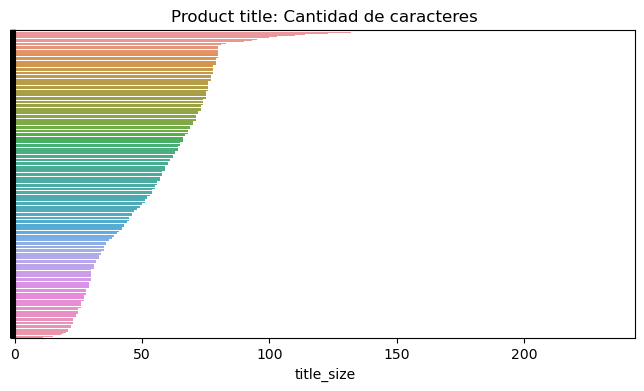

In [142]:
filtered_dataset['title_size'] = filtered_dataset['title'].apply(len)

plot_title(filtered_dataset, column='title_size' ,title='Product title: Cantidad de caracteres')

<Figure size 800x400 with 1 Axes>

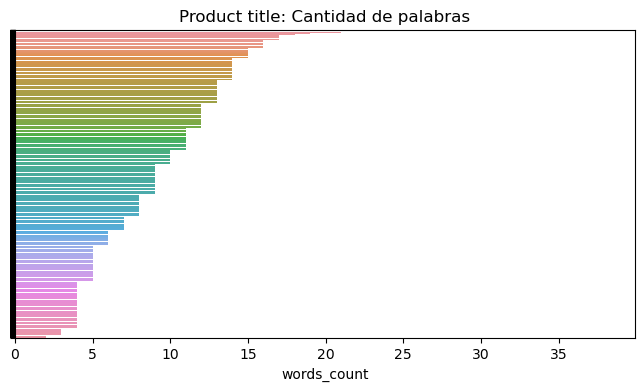

In [143]:
filtered_dataset['words_count'] = filtered_dataset['title'].apply(lambda x: len(x.split(' ')))

plot_title(filtered_dataset, column='words_count', title='Product title: Cantidad de palabras')

<Figure size 800x400 with 1 Axes>

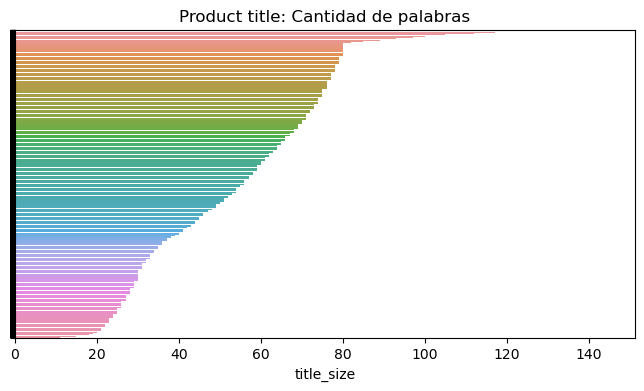

In [144]:
filtered_dataset = filtered_dataset[filtered_dataset['title_size'] < MAX_PRODUCT_TITLE_SIZE]

plot_title(filtered_dataset, column='title_size', title='Product title: Cantidad de palabras')

In [145]:
filtered_dataset['title_size'].min(), filtered_dataset['title_size'].max()

(11, 144)

In [146]:
filtered_dataset = filtered_dataset.drop(columns=['title_size'])
filtered_dataset.head()

,title,category,words_count
2430,Stone Mothers: The addictive new thriller from...,"eBay ~ Books, Comics & Magazines ~ Books",25
2964,Lancashire cycle Map 30: Including The Pennine...,"eBay ~ Books, Comics & Magazines ~ Books",23
2029,Brian May's Red Special: The Story of the Home...,"eBay ~ Books, Comics & Magazines ~ Books",23
620,A Pinch of Salt: Escape to the Highlands with ...,"eBay ~ Books, Comics & Magazines ~ Books",23
2428,Pirata: The dramatic novel of the pirates who ...,"eBay ~ Books, Comics & Magazines ~ Books",23


**Step 5**: Agregamos un número de secuencia que representa univocamente a cada categoria.

In [25]:
filtered_dataset = dt.Sequencer('category', 'category_seq').perform(filtered_dataset)
filtered_dataset.head()

,title,category,category_seq
0,Mrs Sinclair's Suitcase: 'A heart-breaking tal...,"eBay ~ Books, Comics & Magazines ~ Books",0
1,Stone Mothers: The addictive new thriller from...,"eBay ~ Books, Comics & Magazines ~ Books",0
2,Don't Close Your Eyes: The astonishing psychol...,"eBay ~ Books, Comics & Magazines ~ Books",0
3,Regency Scandal: Dissolute Ways: The Runaway C...,"eBay ~ Books, Comics & Magazines ~ Books",0
4,Gone Without A Trace: a gripping psychological...,"eBay ~ Books, Comics & Magazines ~ Books",0


In [26]:
filtered_dataset['category_seq'].min(), filtered_dataset['category_seq'].max()

(0, 121)

**Step 6**: Partimos el dataset en los conjuntos de entrenamiento, prueba y validación. Ademas se estratifica para minimasr el efecto del desbalanceo de prodxcutos por categoria.

In [27]:
train_set, test_set, _, _= train_test_split(
    filtered_dataset,
    filtered_dataset['category'].values,
    test_size     = 0.1,
    stratify      = filtered_dataset['category'].values,
    shuffle       = True
)

In [28]:
test_set, val_set, _, _= train_test_split(
    test_set,
    test_set['category'].values,
    test_size     = 0.5,
    shuffle       = False
)

**Step 7**: Chequeamos que en test y evaliacion existan las misma categorias que existe en train.

<Figure size 720x360 with 1 Axes>

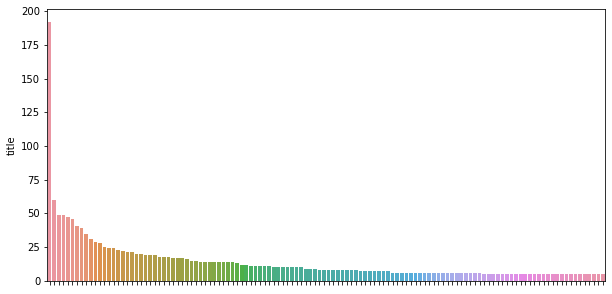

In [29]:
plot_categories(ut.group_by_count(train_set, ['category'], 'title'))

<Figure size 720x360 with 1 Axes>

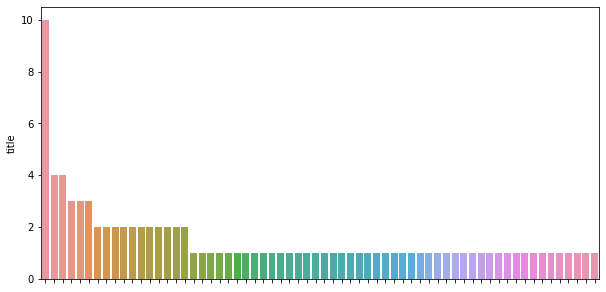

In [30]:
plot_categories(ut.group_by_count(test_set, ['category'], 'title'))

<Figure size 720x360 with 1 Axes>

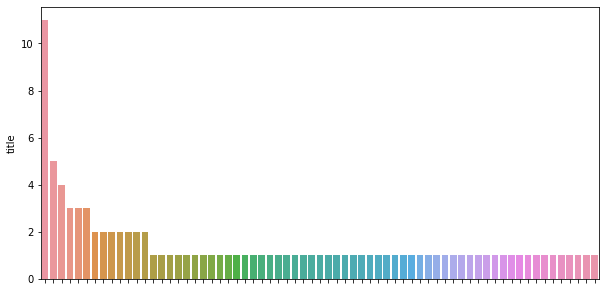

In [31]:
plot_categories(ut.group_by_count(val_set, ['category'], 'title'))

In [32]:
train_set.shape, val_set.shape, test_set.shape

((1731, 3), (97, 3), (96, 3))

Los sets de validación y test deberian tener solo categorias que existan en el set de entrenamiento, de lo contrario, no es posible hacer la predicción:

In [36]:
val_set[val_set['category'].isin(train_set['category'].values)].shape

(97, 3)

In [37]:
test_set[test_set['category'].isin(train_set['category'].values)].shape

(96, 3)

**Step 8**: Guardamos todos los conjuntos preprocesados.

In [39]:
train_set       .to_csv(f'{DATASET_PATH}/ebay-train.csv', index=False)
val_set         .to_csv(f'{DATASET_PATH}/ebay-val.csv',   index=False)
test_set        .to_csv(f'{DATASET_PATH}/ebay-test.csv',  index=False)
filtered_dataset.to_csv(f'{DATASET_PATH}/ebay-all.csv',   index=False)